# Linguistic Description of Songs

Exploring how we can deduce song genres or narrow down artists from a user-inputted linguistic description.

Columns afforded by the Kaggle dataset:
 - acousticness
 - artists
 - danceability
 - duration_ms
 - energy
 - explicit
 - id
 - instrumentalness
 - key
 - liveness
 - loudness
 - mode
 - name
 - popularity
 - release_date
 - speechiness
 - tempo
 - valence
 - year

In [1]:
import nltk
import json
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pandas as pd
import sqlite3

import re
import unidecode as ud

import matplotlib.pyplot as plt

## Standardized Helper Functions

In [34]:
def clean_str(input_artist, cap_code=0):
    """
    Takes in string, returns a unicode-friendly and stripped version of the string.
    """
    return_artist_str = input_artist
    
    # === REGEX REPLACE ===
    repl_tuples = [(r'(^\s+)|(\s+$)', ''),           # whitespace at beg/end of string
                   (r'\s+', ' '),                    # Remove double spaces
                   (r'[\n|\r|\t|\0]+', ' ')
                  ]
    for ptn, repl_str in repl_tuples:
        return_artist_str = re.sub(ptn, repl_str, return_artist_str)
    
    # === UNICODE HANDLING ===
    return_artist_str = ud.unidecode(return_artist_str)
    
    if cap_code == -1: return_artist_str = return_artist_str.lower()
    elif cap_code == 1: return_artist_str = return_artist_str.upper()
    
    return return_artist_str

In [3]:
def read_mard_json(input_filename):
    """
    
    Takes in file name of JSON, returns a list of dictionaries in which
    each element is a row with columns (as the keys).
    
    """
    loaded_data_ = []
    with open(input_filename, 'r') as file_:
        loaded_string_ = file_.read()
        loaded_data_ = [json.loads(s) for s in loaded_string_.split('\n') if s is not None and len(s) > 0]
        file_.close()
    return loaded_data_

In [49]:
def read_mard_json_as_df(input_filename):
    """
    
    Takes in file name of JSON, returns a list of dictionaries in which
    each element is a row with columns (as the keys).
    
    """
    loaded_data_ = []
    with open(input_filename, 'r') as file_:
        loaded_string_ = file_.read()
        loaded_data_ = [json.loads(s) for s in loaded_string_.split('\n') if s is not None and len(s) > 0]
        file_.close()
    return pd.DataFrame(loaded_data_)

In [4]:
def run_query_on_sqlite_db(input_query, input_filename):
    """
    
    Returns a Pandas DataFrame object containing the query results,
    given the user's query and the filename for the sqlite database.
    
    Input:
     - input_query: string representation of the SQL query to run on the sqlite db
     - input_filename: the file location of the sqlite database
     
    """
    conn_ = sqlite3.connect(input_filename)
    df_ = pd.read_sql_query(input_query, conn_)
    conn_.close()
    return df_

## Mard Reviews Dataset

### Loading & Understanding Data

First we load in the data. Data source can be found [here](https://www.upf.edu/web/mtg/mard).

In [5]:
# Loading Metadata
mard_metadata = read_mard_json('../data/raw/mard_reviews/mard_metadata.json')
    
# Loading Reviews
mard_reviews = read_mard_json('../data/raw/mard_reviews/mard_reviews.json')

Then we print some metadata to see what the data looks like.

In [6]:
all_md_keys = set([])
all_rev_keys = set([])
for row in mard_metadata:
    all_md_keys.update(list(row.keys()))
for row in mard_reviews:
    all_rev_keys.update(list(row.keys()))

# Gather all metadata and review keys to see what is going on
all_md_keys = list(all_md_keys)
all_rev_keys = list(all_rev_keys)

In [7]:
print('METADATA KEYS')
print(all_md_keys)
print()
print('REVIEWS KEYS')
print(all_rev_keys)

METADATA KEYS
['first-release-year', 'categories', 'imUrl', 'artist-mbid', 'price', 'title', 'artist', 'release-group-mbid', 'root-genre', 'related', 'amazon-id', 'salesRank', 'brand', 'confidence', 'artist_url', 'release-mbid', 'label', 'songs']

REVIEWS KEYS
['summary', 'reviewerID', 'reviewerName', 'reviewText', 'amazon-id', 'unixReviewTime', 'helpful', 'reviewTime', 'overall']


In [8]:
# Print the first five reviews just to get a sense of the data
for row in mard_reviews[:5]:
    print(row['reviewText'])
    print()

Buy this album. Now.  Don't worry about the reviews.  If you love pure, honest music buy this album....you will not be let down.

The Sudden Passion did a great job with this one. The lyrics are witty, with just the right amount of twang.  This is a whiskey-soaked indie rock jam that captures the soul of modern americana!

I received this CD as a gift a few weeks ago from a friend. I was a bit skeptical at first but decided to try it anyway. This CD is great! The first two tracks talk you through how to use the CD and give you great techniques for breathing. I like track 3 because it's only 10 minutes which helps a lot with my busy schedule. It's already helped me sleep better and feel better during the day. Highly recommended!

I am a beginner and have tried a couple of meditation CDs on the market but have disliked them due to poor audio quality and all the Far East philosophy they try to get you to buy into. I simply wanted a quick way to get started meditating so that I could relie

### Vectorize Dataset

Now we turn it into a usable data structure so that we can start analyzing it. First we turn it into a TF-IDF matrix.

In [ ]:
reviews_list = []
vectorizer = TfidfVectorizer(analyzer='word', stop_words={'english'})

for i,row in enumerate(mard_reviews):
    reviews_list.append(row['reviewText'])

mard_tfidf = vectorizer.fit_transform(reviews_list)
print(mard_tfidf.shape)

### Get Unique Artists

Getting a list of all unique artists in the MARD dataset...

In [11]:
mard_artists = set([])

for row in mard_metadata:
    if 'artist' in row:
        mard_artists.add(clean_str(row['artist'], cap_code=1))

mard_artists = sorted(list(mard_artists))
        
print("Number of unique artists:", len(mard_artists))

Number of unique artists: 36676


## Pitchfork Reviews Dataset

### Loading and Understanding the Data

Loading in sqlite db. Source: [link](https://www.kaggle.com/nolanbconaway/pitchfork-data).

In [12]:
all_pf_tables = ['artists', 'content', 'genres', 'labels', 'reviews', 'years']
pitchfork_db = {}

for table in all_pf_tables:
    pitchfork_db[table] = run_query_on_sqlite_db("SELECT * FROM " + table, "../data/raw/pitchfork_reviews.sqlite")

In [13]:
# Printing all unique genres in db
print("Unique genres in db:")
print(pd.unique(pitchfork_db['genres']['genre']))

Unique genres in db:
['electronic' 'metal' 'rock' None 'rap' 'experimental' 'pop/r&b'
 'folk/country' 'jazz' 'global']


In [14]:
print("SAMPLE OF REVIEW TITLES")
print(pitchfork_db['reviews']['title'][:20])

SAMPLE OF REVIEW TITLES
0                                             mezzanine
1                                          prelapsarian
2                                  all of them naturals
3                                           first songs
4                                             new start
5         insecure (music from the hbo original series)
6                               stillness in wonderland
7                                              tehillim
8                                            reflection
9                          filthy america its beautiful
10                                clear sounds/perfetta
11                                     run the jewels 3
12                                                nadir
13                                        december 99th
14                                     don't smoke rock
15    punk45: les punks: the french connection (the ...
16                                      brnshj (puncak)
17                      

In [15]:
print("SAMPLE OF REVIEW CONTENT")
print(pitchfork_db['content']['content'][:20])

SAMPLE OF REVIEW CONTENT
0     “Trip-hop” eventually became a ’90s punchline,...
1     Eight years, five albums, and two EPs in, the ...
2     Minneapolis’ Uranium Club seem to revel in bei...
3     Kleenex began with a crash. It transpired one ...
4     It is impossible to consider a given release b...
5     In the pilot episode of “Insecure,” the critic...
6     Rapper Simbi Ajikawo, who records as Little Si...
7     For the last thirty years, Israel’s electronic...
8     Ambient music is a funny thing. As innocuous a...
9     There were innumerable cameos at the Bad Boy F...
10    Lots of drone musicians have been called sound...
11    On 2006’s “That’s Life,” Killer Mike boasted “...
12    “Why so sad?/Don’t feel so bad/Get out of bed,...
13    In January 2016, rapper/actor Yasiin Bey annou...
14    Don’t take your eyes off Pete Rock. The early-...
15    Soul Jazz’s Punk 45 series has made it its mis...
16    It’s safe to say there is no other band on the...
17    When Chance the R

### Get Unique Artists

In [16]:
pitchfork_artists = sorted([clean_str(a, cap_code=1) for a in pd.unique(pitchfork_db['artists']['artist'])])

print("Num unique artists:", len(pitchfork_artists))
print()
print("First twenty artists (alphabetic order):")
print(sorted(pitchfork_artists)[:20])

Num unique artists: 8633

First twenty artists (alphabetic order):
['', '!!!', '+/-', '-ZIQ', '...AND YOU WILL KNOW US BY THE TRAIL OF DEAD', '1,2,3', '10 IN THE SWEAR JAR', '11:11', '12 RODS', '120 DAYS', '13 & GOD', '13GHOSTS', '13TH FLOOR ELEVATORS', '1990S', '2 CHAINZ', '2 MANY DJS', '20 MILES', '20 MINUTE LOOP', '200 YEARS', '21 SAVAGE']


## Comparing Artist Lists

Comparing against the list of artists from our baseline TFIDF matrix for artist search.

In [17]:
kaggle_tfidf = pd.read_csv("../data/processed/tfidf_mat_compressed.csv")
kaggle_artists = sorted([ clean_str(s, cap_code=1) for s in kaggle_tfidf.values[:,0] ])

print(kaggle_artists[:20])

['"CATS" 1981 ORIGINAL LONDON CAST', '"WEIRD AL" YANKOVIC', '$ATORI ZOOM', '$NOT', "'IN THE HEIGHTS' ORIGINAL BROADWAY COMPANY", '((( O )))', '(EM)', '*SPANDREL', '03 GREEDO', '070 SHAKE', '10 YEARS', '100 GECS', '1927', '2 CHAINZ', '20/20', '21 SAVAGE', '24HRS', '24KGOLDN', '27CLUB', '2KBABY']


In [18]:
# Store artist sets from different databases in a single dictionary
artist_sets = {}
artist_sets['tfidf'] = set(kaggle_artists)
artist_sets['pitchfork'] = set(pitchfork_artists)
artist_sets['mard'] = set(mard_artists)

Basic intersection of artist strings

In [19]:
# Store intersections into variables for easy access
tf_pf = list(artist_sets['tfidf'].intersection(artist_sets['pitchfork']))
tf_mard = list(artist_sets['tfidf'].intersection(artist_sets['mard']))
pf_mard = list(artist_sets['pitchfork'].intersection(artist_sets['mard']))
tf_pfmard = list(artist_sets['tfidf'].intersection(artist_sets['pitchfork'].union(artist_sets['mard'])))
                                          
print("TFIDF && pitchfork:", len(tf_pf))
print("TFIDF && mard:", len(tf_mard))
print("pitchfork && mard:", len(pf_mard))
print("TFIDF && (pitchfork || mard):", len(tf_pfmard))

TFIDF && pitchfork: 497
TFIDF && mard: 1220
pitchfork && mard: 1216
TFIDF && (pitchfork || mard): 1509


In [20]:
print("FIRST 30 ARTISTS IN (TFIDF && (pitchfork || mard)):\n")
print(tf_pfmard[:30])

FIRST 30 ARTISTS IN (TFIDF && (pitchfork || mard)):

['MAELO RUIZ', 'KEHLANI', 'PAUL BADURA-SKODA', 'WET WET WET', 'CECILIA', 'EMANUEL AX', 'JON NAKAMATSU', 'COMMON', 'THE PRESIDENTS OF THE UNITED STATES OF AMERICA', 'MANCHESTER ORCHESTRA', 'TWISTA', 'JOSS STONE', 'NAT KING COLE', 'RIDE', 'MIX MASTER MIKE', 'SAVAGE', 'TIM MCGRAW', 'EL TRONO DE MEXICO', 'CULTURE BEAT', 'EVE', 'BUJU BANTON', 'GUAYACAN ORQUESTA', 'PHISH', 'JOHN LEGEND', 'BTS', 'ELECTRIC GUEST', 'ELLIE GOULDING', 'TALK TALK', 'DUNCAN DHU', 'DESIIGNER']


## Mapping Artist to Review Content

In [21]:
# We assign which list of artists will be our finalized
# list of artists to consult for reviews.
ALL_ARTISTS = tf_pfmard

### Artist to Index Mapping

In [22]:
a_to_i = {a:i for i,a in enumerate(ALL_ARTISTS)}

### Review Retrieval Functions

In [42]:
pf_reviews_df = run_query_on_sqlite_db(
    """
    SELECT reviews.title, reviews.artist, reviews.score, content.content
      FROM content
      LEFT JOIN reviews
      ON content.reviewid = reviews.reviewid
    """, "../data/raw/pitchfork_reviews.sqlite")

In [43]:
print(pf_reviews_df.keys())

Index(['title', 'artist', 'score', 'content'], dtype='object')


In [ ]:
# TODO: Delete cell
reviews_list = []
vectorizer = TfidfVectorizer(analyzer='word', stop_words={'english'})

for i,row in enumerate(mard_reviews):
    reviews_list.append(row['reviewText'])

mard_tfidf = vectorizer.fit_transform(reviews_list)
print(mard_tfidf.shape)

In [86]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words={'english'})

In [151]:
def process_reviews(input_artist_list, input_dataframe, max_reviews=30):
    """
    
    Maps artist name to a list of reviews written about that artist.
    
    """
    artist_to_review_dict = {}

    # Initialize dictionary of all artists
    for artist in input_artist_list:
        artist_to_review_dict[artist] = []

    # Iterate through DataFrame to sanitize strings 
    # and add reviews to dict
    for i,row in input_dataframe.iterrows():
        if type(row['artist']) != str or len(row['artist']) == 0:
            continue
        temp_artist = clean_str(row['artist'], cap_code=1)
        if temp_artist in artist_to_review_dict and len(artist_to_review_dict[temp_artist]) <= max_reviews:
            temp_review_string = ""
            if type(row['title']) == str and len(row['title']) > 0:
                temp_review_string += clean_str(row['title'])
            if type(row['content']) == str and len(row['content']) > 0:
                temp_review_string += clean_str(row['content']) if len(temp_review_string)==0 else " - " + clean_str(row['content'])
            
            artist_to_review_dict[temp_artist].append(temp_review_string)
    
    return artist_to_review_dict

pf_atr_dict = process_reviews(ALL_ARTISTS, pf_reviews_df)

In [52]:
# Loading Data as DataFrames
mard_md_df = read_mard_json_as_df('../data/raw/mard_reviews/mard_metadata.json')
mard_rev_df = read_mard_json_as_df('../data/raw/mard_reviews/mard_reviews.json')

In [54]:
# Create a joined DataFrame that has 'artist', 'title', and 'content' fields.
print(mard_md_df.keys())
print(mard_rev_df.keys())

Index(['price', 'artist-mbid', 'imUrl', 'confidence', 'categories',
       'release-group-mbid', 'amazon-id', 'root-genre', 'title', 'artist',
       'label', 'artist_url', 'first-release-year', 'release-mbid', 'songs',
       'salesRank', 'related', 'brand'],
      dtype='object')
Index(['reviewerID', 'amazon-id', 'reviewerName', 'helpful', 'unixReviewTime',
       'reviewText', 'overall', 'reviewTime', 'summary'],
      dtype='object')


In [63]:
mard_combined_dataframe = mard_md_df.merge(mard_rev_df, on='amazon-id', how='left')

In [79]:
temp_columns_to_drop = ['artist-mbid', 'amazon-id', 
                        'label', 'artist_url', 'first-release-year', 
                        'songs', 'salesRank', 'related', 'brand', 
                        'reviewerID', 'reviewerName', 'helpful', 'unixReviewTime', 
                        'overall', 'reviewTime', 'summary']

mard_combined_dataframe = mard_combined_dataframe.rename(columns={'reviewText': 'content'})
mard_combined_dataframe = mard_combined_dataframe.drop(columns=temp_columns_to_drop)

['artist-mbid', 'amazon-id', 'title', 'artist', 'label', 'artist_url', 'first-release-year', 'songs', 'salesRank', 'related', 'brand', 'reviewerID', 'reviewerName', 'helpful', 'unixReviewTime', 'content', 'overall', 'reviewTime', 'summary']


In [152]:
mard_atr_dict = process_reviews(ALL_ARTISTS, mard_combined_dataframe)

In [109]:
def get_pf_review(input_artist):
    """
    Gets all Pitchfork reviews for the given artist.
    
    Input: 
    - input_artist (string)
    
    Output:
    - list of reviews for given artist. returns empty list if no reviews
      exist for the artist, or if the artist is not in the db.
    
    """
    return pf_atr_dict[input_artist] if len(pf_atr_dict[input_artist]) > 0 else []

In [110]:
def get_mard_review(input_artist):
    """
    Gets all MARD reviews for the given artist.
    
    Input: 
    - input_artist (string)
    
    Output:
    - list of reviews for given artist. returns empty list if no reviews
      exist for the artist, or if the artist is not in the db.
    
    """
    return mard_atr_dict[input_artist] if len(mard_atr_dict[input_artist]) > 0 else []

In [133]:
def get_review_list(input_artist):
    extended_list = get_mard_review(input_artist)
    extended_list.extend(get_pf_review(input_artist))
    return extended_list

In [164]:
pd.concat([pf_reviews_df, mard_combined_dataframe]).drop(columns=["score"])

,title,artist,content
0,mezzanine,massive attack,"“Trip-hop” eventually became a ’90s punchline,..."
1,prelapsarian,krallice,"Eight years, five albums, and two EPs in, the ..."
2,all of them naturals,uranium club,Minneapolis’ Uranium Club seem to revel in bei...
3,first songs,"kleenex, liliput",Kleenex began with a crash. It transpired one ...
4,new start,taso,It is impossible to consider a given release b...
...,...,...,...
264449,Echo,After Jack,Something magical happens when these three lad...
264450,Let's Move the World,Lila Garrett & Keaton Simons,"Keaton is a brilliant singer, and he and Ms. G..."
264451,Inside Llewyn Davis : Movie Soundtrack & Other...,"Ramblin' Jack Elliot, Joan Beaz,Andrew Rown Su...","A large varity of music, and groups I was not ..."
264452,Inside Llewyn Davis : Movie Soundtrack & Other...,"Ramblin' Jack Elliot, Joan Beaz,Andrew Rown Su...",Good ole Ry Cooder. He must know every good mu...


In [153]:
combined_revs = np.array([ len(get_review_list(a)) if a else 0 for a in ALL_ARTISTS ])
print('Avg:', np.average(combined_revs))
print('Median:', np.median(combined_revs))
print('Max:', np.max(combined_revs))

Avg: 9.068257123923129
Median: 4.0
Max: 52


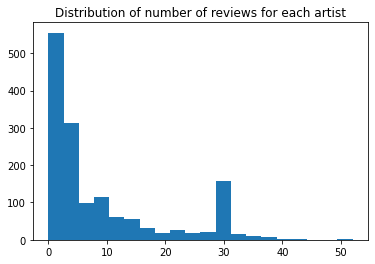

In [157]:
plt.hist(combined_revs, 20)
plt.title('Distribution of number of reviews for each artist')
plt.show()

In [160]:
print("Maximum reviews:", ALL_ARTISTS[np.argmax(combined_revs)])
print("Minimum reviews:", ALL_ARTISTS[np.argmin(combined_revs)])

Maximum reviews: THE BEATLES
Minimum reviews: METRO BOOMIN


In [162]:
len(np.argwhere(combined_revs>0))

1500

# Analyzing Reviews

In [8]:
with open("../data/processed/artist_reviews.json") as f:
    d = json.load(f)
    f.close()
REVIEWS_DICT = d
ARTISTS_LIST = list(REVIEWS_DICT.keys())

In [42]:
def make_tfidf_vectorizer(input_artist_to_reviews, input_all_artists):
    """
    Returns TFIDF Vectorizer matrix where each document is an artist and the terms are words in the reviews.
    """
    vectorizer = TfidfVectorizer(analyzer='word', stop_words={'english'}, max_df=0.8, min_df=2)
    consolidated_reviews = []
    for a in input_all_artists:
        consolidated_reviews.append(" ".join(input_artist_to_reviews[a]))
    return vectorizer,vectorizer.fit_transform(consolidated_reviews)

In [43]:
def make_count_vectorizer(input_artist_to_reviews, input_all_artists):
    """
    Returns TFIDF Vectorizer matrix where each document is an artist and the terms are words in the reviews.
    """
    vectorizer = CountVectorizer(analyzer='word', stop_words={'english'}, max_df=0.8, min_df=2)
    consolidated_reviews = []
    for a in input_all_artists:
        consolidated_reviews.append(" ".join(input_artist_to_reviews[a]))
    return vectorizer,vectorizer.fit_transform(consolidated_reviews)

In [44]:
tfdif_vec, tfidf_mat = make_tfidf_vectorizer(REVIEWS_DICT, ARTISTS_LIST)

In [45]:
count_vec, count_mat = make_count_vectorizer(REVIEWS_DICT, ARTISTS_LIST)

In [27]:
print(review_vec.get_feature_names())

['10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '1960s', '1970', '1970s', '1980s', '1990', '1990s', '1997', '1998', '1999', '1st', '20', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '20th', '21', '22', '24', '25', '2nd', '30', '34', '40', '45', '50', '60', '60s', '70', '70s', '80', '80s', '90', '90s', 'aacute', 'ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'accessible', 'accompaniment', 'accomplished', 'acoustic', 'across', 'act', 'action', 'acts', 'actual', 'actually', 'add', 'added', 'adding', 'addition', 'adds', 'admit', 'adult', 'aesthetic', 'aforementioned', 'afraid', 'after', 'again', 'against', 'age', 'aggressive', 'ago', 'agree', 'ahead', 'ain', 'air', 'al', 'album', 'albums', 'alive', 'all', 'allow', 'allowed', 'allows', 'almost', 'alone', 'along', 'alongside', 'already', 'also', 'alternate', 'alternative', 'although', 'always', 'am', 'amazing', 'amazon', 'ambient', 'ambit

In [28]:
def cossim(query_vec, input_mtx, input_artists=ARTISTS_LIST):
    scores = input_mtx.dot(query_vec)
    ranking = np.argsort(scores)
    return [(input_artists[i], scores[i]) for i in ranking[::-1]]

In [48]:
test_query = "in addition i arrived art artists behind being believe of course but why"

print(count_vec.fit_transform([test_query]))

ValueError: max_df corresponds to < documents than min_df

In [49]:
string_tokenizer = count_vec.build_tokenizer()

string_tokenizer(test_query)

['in',
 'addition',
 'arrived',
 'art',
 'artists',
 'behind',
 'being',
 'believe',
 'of',
 'course',
 'but',
 'why']

In [107]:
class ArtistReviewAnalyzer:
    def __init__(self, fileloc, min_df=2, max_df=0.8):
        self.__tokenizer = self.count_vectorizer.build_tokenizer()
        self.raw = ArtistReviewAnalyzer.load_json(fileloc)
        self.artists_list = list(self.raw.keys())
        self.tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words={'english'}, min_df=min_df, max_df=max_df)
        self.count_vectorizer = CountVectorizer(analyzer='word', stop_words={'english'}, min_df=min_df, max_df=max_df)

        # Spacy tool
        self.nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

        # List of lists of strings
        self.tokenized_reviews = self.build_reviews_list(do_tokenize=True)

        # Stop words
        self.stop_words = self.build_stopwords()

        self.bigrams = None
        self.lemmatized_text = None
        self.lda_model = self.make_lda_model(num_topics=20)

        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.raw_reviews)
        self.count_matrix = self.count_vectorizer.fit_transform(self.raw_reviews)
        self.raw_reviews = self.build_reviews_list()  # List of strings

    def build_stopwords(self):
        sw = stopwords.words('english')
        sw.extend(['album', 'music', 'cd', 'track', 'song', 'sound'])
        return sw

    def update_stopwords(self, word_list):
        self.stopwords.extend(word_list)
        return None

    def remove_stopwords(self):
        self.tokenized_reviews = [[w for w in artist_review if w not in self.stop_words] for artist_review in self.tokenized_reviews]

    def make_bigrams(self):
        bg = gensim.models.Phrases(self.tokenized_reviews, min_count=5, threshold=100)
        bg_mod = gensim.models.phrases.Phraser(bg)
        return [bg_mod[d] for d in self.tokenized_reviews]

    def lemmatize(self, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        texts_out = []
        for review_words in self.tokenized_reviews:
            joined_words = self.nlp(" ".join(review_words))
            texts_out.append([token.lemma_ for token in joined_words if token.pos_ in allowed_postags])
        return texts_out

    def make_lda_model(self, num_topics):
        self.bigrams = self.make_bigrams()
        self.lemmatized_text = self.lemmatize()
        id2word = corpora.Dictionary(self.lemmatized_text)
        corpus = [id2word.doc2bow(w) for w in self.lemmatized_text]
        return gensim.models.ldamodel.LdaModel(corpus, id2word, num_topics)

    def tokenize(self, input_string):
        return self.__tokenizer(input_string)

    def build_reviews_list(self, do_tokenize=False):
        consolidated_reviews = []
        for a in self.artists_list:
            if do_tokenize:
                consolidated_reviews.append(self.tokenize(" ".join(self.raw[a])))
            else:
                consolidated_reviews.append(" ".join(self.raw[a]))
        return consolidated_reviews

    def get_all_words(self, do_tokenize=False):
        return self.tokenize(" ".join(self.raw_reviews)) if do_tokenize else " ".join(self.raw_reviews)

    @staticmethod
    def load_json(fileloc):
        with open(fileloc, 'r') as file:
            d = json.load(file)
            file.close()
        return d


In [81]:
artist_analyzer = ArtistReviewAnalyzer("../data/processed/artist_reviews.json")

In [82]:
artist_analyzer.tokenize(test_query)
print(len(artist_analyzer.get_all_words()))

17822772


In [85]:
from pprint import pprint
import gensim
import gensim.corpora as corpora
import nltk; nltk.download('stopwords')
import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celinechoo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [86]:
from nltk.corpus import stopwords

In [83]:
id2word = corpora.Dictionary(artist_analyzer.tokenized_reviews)
texts = artist_analyzer.tokenized_reviews
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 4), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 5), (25, 1), (26, 6), (27, 10), (28, 1), (29, 1)]


In [84]:
num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"the" + 0.030*"of" + 0.021*"and" + 0.017*"to" + 0.016*"is" + '
  '0.011*"it" + 0.011*"in" + 0.010*"that" + 0.009*"this" + 0.009*"with"'),
 (1,
  '0.042*"the" + 0.023*"of" + 0.021*"and" + 0.020*"to" + 0.014*"is" + '
  '0.010*"in" + 0.008*"that" + 0.008*"it" + 0.008*"The" + 0.008*"this"'),
 (2,
  '0.032*"the" + 0.022*"of" + 0.019*"and" + 0.016*"is" + 0.015*"to" + '
  '0.011*"it" + 0.010*"with" + 0.010*"this" + 0.008*"in" + 0.008*"that"'),
 (3,
  '0.054*"the" + 0.028*"and" + 0.026*"of" + 0.019*"to" + 0.017*"is" + '
  '0.014*"in" + 0.013*"that" + 0.010*"on" + 0.009*"it" + 0.009*"this"'),
 (4,
  '0.032*"the" + 0.028*"and" + 0.023*"of" + 0.018*"to" + 0.014*"is" + '
  '0.012*"it" + 0.012*"in" + 0.009*"that" + 0.008*"with" + 0.008*"The"'),
 (5,
  '0.050*"the" + 0.031*"of" + 0.029*"and" + 0.017*"to" + 0.014*"is" + '
  '0.011*"in" + 0.010*"it" + 0.009*"that" + 0.008*"this" + 0.008*"for"'),
 (6,
  '0.034*"the" + 0.029*"to" + 0.029*"of" + 0.026*"and" + 0.013*"is" + '
  '0.012*"that" 

In [106]:
stop_words = stopwords.words('english')
stop_words.extend(['album', 'music', 'cd', 'track', 'song', 'sound'])

reviews_nostop = [[w for w in artist_review if w not in stop_words] for artist_review in artist_analyzer.tokenized_reviews]

In [89]:
def make_bigrams(texts):
    bigram = gensim.models.Phrases(artist_analyzer.tokenized_reviews, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [98]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [99]:
test_bigrams = make_bigrams(reviews_nostop)

In [100]:
test_lemmatized = lemmatization(test_bigrams)

In [104]:
test_id2word = corpora.Dictionary(test_lemmatized)
test_lda_model = gensim.models.ldamodel.LdaModel(corpus=[test_id2word.doc2bow(text) for text in test_lemmatized],
                                                 id2word=test_id2word,
                                                 num_topics=20)

In [105]:
pprint(test_lda_model.print_topics())

[(0,
  '0.010*"album" + 0.009*"music" + 0.008*"sound" + 0.007*"song" + 0.007*"make" '
  '+ 0.006*"record" + 0.005*"well" + 0.005*"good" + 0.005*"band" + 0.005*"cd"'),
 (1,
  '0.009*"album" + 0.007*"song" + 0.007*"sound" + 0.007*"music" + 0.006*"good" '
  '+ 0.005*"make" + 0.005*"first" + 0.005*"band" + 0.005*"record" + '
  '0.004*"track"'),
 (2,
  '0.013*"song" + 0.012*"album" + 0.010*"music" + 0.008*"cd" + 0.008*"good" + '
  '0.007*"great" + 0.007*"time" + 0.006*"well" + 0.006*"make" + 0.006*"love"'),
 (3,
  '0.017*"song" + 0.014*"album" + 0.011*"cd" + 0.010*"music" + 0.009*"good" + '
  '0.008*"great" + 0.007*"sound" + 0.007*"love" + 0.007*"get" + 0.007*"track"'),
 (4,
  '0.013*"album" + 0.011*"song" + 0.008*"good" + 0.008*"music" + 0.007*"sound" '
  '+ 0.007*"get" + 0.006*"quot" + 0.006*"record" + 0.006*"track" + 0.006*"cd"'),
 (5,
  '0.020*"album" + 0.017*"song" + 0.011*"music" + 0.009*"good" + 0.008*"sound" '
  '+ 0.007*"make" + 0.007*"track" + 0.007*"band" + 0.007*"quot" + '
  '0.

In [112]:
class ArtistReviewAnalyzer:
    def __init__(self, fileloc, min_df=2, max_df=0.8):
        self.raw = ArtistReviewAnalyzer.load_json(fileloc)
        self.artists_list = list(self.raw.keys())
        # self.tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words={'english'}, min_df=min_df, max_df=max_df)
        self.count_vectorizer = CountVectorizer(analyzer='word', stop_words={'english'}, min_df=min_df, max_df=max_df)
        self.__tokenizer = self.count_vectorizer.build_tokenizer()

        # Spacy tool
        self.nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

        # List of lists of strings
        self.tokenized_reviews = self.build_reviews_list(do_tokenize=True)

        # Stop words
        self.stop_words = self.build_stopwords()

        self.bigrams = None
        self.lemmatized_text = None
        self.lda_model = self.make_lda_model(num_topics=20)

        # self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.raw_reviews)
        # self.count_matrix = self.count_vectorizer.fit_transform(self.raw_reviews)
        # self.raw_reviews = self.build_reviews_list()  # List of strings

    def build_stopwords(self):
        sw = stopwords.words('english')
        sw.extend(['album', 'music', 'cd', 'track', 'song', 'sound'])
        return sw

    def update_stopwords(self, word_list):
        self.stopwords.extend(word_list)
        return None

    def remove_stopwords(self):
        self.tokenized_reviews = [[w for w in artist_review if w not in self.stop_words] for artist_review in self.tokenized_reviews]

    def make_bigrams(self):
        bg = gensim.models.Phrases(self.tokenized_reviews, min_count=5, threshold=100)
        bg_mod = gensim.models.phrases.Phraser(bg)
        return [bg_mod[d] for d in self.tokenized_reviews]

    def lemmatize(self, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        texts_out = []
        for review_words in self.tokenized_reviews:
            joined_words = self.nlp(" ".join(review_words))
            texts_out.append([token.lemma_ for token in joined_words if token.pos_ in allowed_postags])
        return texts_out

    def make_lda_model(self, num_topics):
        self.bigrams = self.make_bigrams()
        self.lemmatized_text = self.lemmatize()
        id2word = corpora.Dictionary(self.lemmatized_text)
        corpus = [id2word.doc2bow(w) for w in self.lemmatized_text]
        return gensim.models.ldamodel.LdaModel(corpus, id2word, num_topics)

    def tokenize(self, input_string):
        return self.__tokenizer(input_string)

    def build_reviews_list(self, do_tokenize=False):
        consolidated_reviews = []
        for a in self.artists_list:
            if do_tokenize:
                consolidated_reviews.append(self.tokenize(" ".join(self.raw[a])))
            else:
                consolidated_reviews.append(" ".join(self.raw[a]))
        return consolidated_reviews

    def get_all_words(self, do_tokenize=False):
        return self.tokenize(" ".join(self.raw_reviews)) if do_tokenize else " ".join(self.raw_reviews)

    @staticmethod
    def load_json(fileloc):
        with open(fileloc, 'r') as file:
            d = json.load(file)
            file.close()
        return d


In [113]:
artist_analyzer = ArtistReviewAnalyzer("../data/processed/artist_reviews.json")

TypeError: object of type 'int' has no len()